Updated: 20/02/2024

This workbook focusses on testing for other quadratic modes present in other spherical modes. 

#### Note: Models now include p = -1 modes to account for bias towards these linear terms in nonlinear memory fits!!! This needs removing for other quadratic QNMs

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import qnmfitsrd as qnmfits
from multiprocessing import Pool
from spatial_reconstruction import *
from matplotlib.animation import FuncAnimation
from scipy.interpolate import UnivariateSpline
from Visualisation.qnm_vis import * 
from qnmfitsrd.CCE_file_getter import *
import datetime
from scipy.optimize import least_squares

l_max = 7
n_max = 7

In [2]:
CCE_sim1 = CCE_to_sim_simplified(sim_num='0001')
CCE_sim2 = CCE_to_sim_simplified(sim_num='0002')
CCE_sim3 = CCE_to_sim_simplified(sim_num='0003')
CCE_sim4 = CCE_to_sim_simplified(sim_num='0004')
CCE_sim5 = CCE_to_sim_simplified(sim_num='0005')
CCE_sim6 = CCE_to_sim_simplified(sim_num='0006')
CCE_sim7 = CCE_to_sim_simplified(sim_num='0007')
CCE_sim8 = CCE_to_sim_simplified(sim_num='0008')
CCE_sim9 = CCE_to_sim_simplified(sim_num='0009')
CCE_sim10 = CCE_to_sim_simplified(sim_num='0010')
CCE_sim11 = CCE_to_sim_simplified(sim_num='0011')
CCE_sim12 = CCE_to_sim_simplified(sim_num='0012')
CCE_sim13 = CCE_to_sim_simplified(sim_num='0013')

CCE_sim305 = CCE_to_sim_simplified(sim_num='0305')

In [3]:
sim_1502 = qnmfits.SXS(ID=1502, zero_time='norm')
sim_1476 = qnmfits.SXS(ID=1476, zero_time='norm')
sim_1506 = qnmfits.SXS(ID=1506, zero_time='norm')
sim_1508 = qnmfits.SXS(ID=1508, zero_time='norm')
sim_1474 = qnmfits.SXS(ID=1474, zero_time='norm')
sim_1505 = qnmfits.SXS(ID=1505, zero_time='norm')
sim_1504 = qnmfits.SXS(ID=1504, zero_time='norm')
sim_1485 = qnmfits.SXS(ID=1485, zero_time='norm')
sim_1486 = qnmfits.SXS(ID=1486, zero_time='norm')
sim_1441 = qnmfits.SXS(ID=1441, zero_time='norm')
sim_1500 = qnmfits.SXS(ID=1500, zero_time='norm')
sim_1492 = qnmfits.SXS(ID=1492, zero_time='norm')
sim_1465 = qnmfits.SXS(ID=1465, zero_time='norm')
sim_1458 = qnmfits.SXS(ID=1458, zero_time='norm')
sim_1438 = qnmfits.SXS(ID=1438, zero_time='norm')
sim_1430 = qnmfits.SXS(ID=1430, zero_time='norm')

/data/rvnd2/python_envs/python-3.11-clone/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Skipping download from 'https://data.black-holes.org/catalog.json' because local file is newer
Found the following files to load from the SXS catalog:
    SXS:BBH:1502v5/Lev3/metadata.json
Found the following files to load from the SXS catalog:
    SXS:BBH:1502v5/Lev3/rhOverM_Asymptotic_GeometricUnits_CoM.h5


100%|██████████| 83.0M/83.0M [00:14<00:00, 5.84MB/s]


Found the following files to load from the SXS catalog:
    SXS:BBH:1476v5/Lev3/metadata.json
Found the following files to load from the SXS catalog:
    SXS:BBH:1476v5/Lev3/rhOverM_Asymptotic_GeometricUnits_CoM.h5


100%|██████████| 80.4M/80.4M [00:13<00:00, 6.16MB/s]


Found the following files to load from the SXS catalog:
    SXS:BBH:1506v5/Lev3/metadata.json
Found the following files to load from the SXS catalog:
    SXS:BBH:1506v5/Lev3/rhOverM_Asymptotic_GeometricUnits_CoM.h5


100%|██████████| 82.8M/82.8M [00:14<00:00, 5.89MB/s]


Found the following files to load from the SXS catalog:
    SXS:BBH:1508v5/Lev3/metadata.json
Found the following files to load from the SXS catalog:
    SXS:BBH:1508v5/Lev3/rhOverM_Asymptotic_GeometricUnits_CoM.h5


100%|██████████| 83.7M/83.7M [00:24<00:00, 3.59MB/s]


Found the following files to load from the SXS catalog:
    SXS:BBH:1474v5/Lev3/metadata.json
Found the following files to load from the SXS catalog:
    SXS:BBH:1474v5/Lev3/rhOverM_Asymptotic_GeometricUnits_CoM.h5


100%|██████████| 81.5M/81.5M [00:13<00:00, 6.25MB/s]


Found the following files to load from the SXS catalog:
    SXS:BBH:1505v5/Lev3/metadata.json
Found the following files to load from the SXS catalog:
    SXS:BBH:1505v5/Lev3/rhOverM_Asymptotic_GeometricUnits_CoM.h5


100%|██████████| 83.3M/83.3M [00:14<00:00, 6.08MB/s]


Found the following files to load from the SXS catalog:
    SXS:BBH:1504v5/Lev3/metadata.json
Found the following files to load from the SXS catalog:
    SXS:BBH:1504v5/Lev3/rhOverM_Asymptotic_GeometricUnits_CoM.h5


100%|██████████| 84.4M/84.4M [00:14<00:00, 6.10MB/s]


Found the following files to load from the SXS catalog:
    SXS:BBH:1485v5/Lev3/metadata.json
Found the following files to load from the SXS catalog:
    SXS:BBH:1485v5/Lev3/rhOverM_Asymptotic_GeometricUnits_CoM.h5


100%|██████████| 84.8M/84.8M [00:15<00:00, 5.62MB/s]


Found the following files to load from the SXS catalog:
    SXS:BBH:1486v5/Lev3/metadata.json
Found the following files to load from the SXS catalog:
    SXS:BBH:1486v5/Lev3/rhOverM_Asymptotic_GeometricUnits_CoM.h5


100%|██████████| 86.5M/86.5M [00:16<00:00, 5.64MB/s]


Found the following files to load from the SXS catalog:
    SXS:BBH:1441v5/Lev3/metadata.json
Found the following files to load from the SXS catalog:
    SXS:BBH:1441v5/Lev3/rhOverM_Asymptotic_GeometricUnits_CoM.h5


100%|██████████| 96.0M/96.0M [00:17<00:00, 5.83MB/s]


Found the following files to load from the SXS catalog:
    SXS:BBH:1500v5/Lev3/metadata.json
Found the following files to load from the SXS catalog:
    SXS:BBH:1500v5/Lev3/rhOverM_Asymptotic_GeometricUnits_CoM.h5


100%|██████████| 79.7M/79.7M [00:15<00:00, 5.51MB/s]


Found the following files to load from the SXS catalog:
    SXS:BBH:1492v5/Lev3/metadata.json
Found the following files to load from the SXS catalog:
    SXS:BBH:1492v5/Lev3/rhOverM_Asymptotic_GeometricUnits_CoM.h5


100%|██████████| 78.5M/78.5M [00:13<00:00, 6.25MB/s]


Found the following files to load from the SXS catalog:
    SXS:BBH:1465v5/Lev3/metadata.json
Found the following files to load from the SXS catalog:
    SXS:BBH:1465v5/Lev3/rhOverM_Asymptotic_GeometricUnits_CoM.h5


100%|██████████| 78.6M/78.6M [00:13<00:00, 5.94MB/s]


Found the following files to load from the SXS catalog:
    SXS:BBH:1458v5/Lev3/metadata.json
Found the following files to load from the SXS catalog:
    SXS:BBH:1458v5/Lev3/rhOverM_Asymptotic_GeometricUnits_CoM.h5


100%|██████████| 80.8M/80.8M [00:13<00:00, 6.18MB/s]


Found the following files to load from the SXS catalog:
    SXS:BBH:1438v5/Lev3/metadata.json
Found the following files to load from the SXS catalog:
    SXS:BBH:1438v5/Lev3/rhOverM_Asymptotic_GeometricUnits_CoM.h5


100%|██████████| 85.1M/85.1M [00:15<00:00, 5.83MB/s]


Found the following files to load from the SXS catalog:
    SXS:BBH:1430v5/Lev3/metadata.json
Found the following files to load from the SXS catalog:
    SXS:BBH:1430v5/Lev3/rhOverM_Asymptotic_GeometricUnits_CoM.h5


100%|██████████| 88.3M/88.3M [00:15<00:00, 6.03MB/s]


# Reproducing Fig. 1

Note this doesn't use the CCE waveforms.

Assume linear model fits to a particular l,m using only the QNM harmonics of that l,m

### Does this apply to m=0

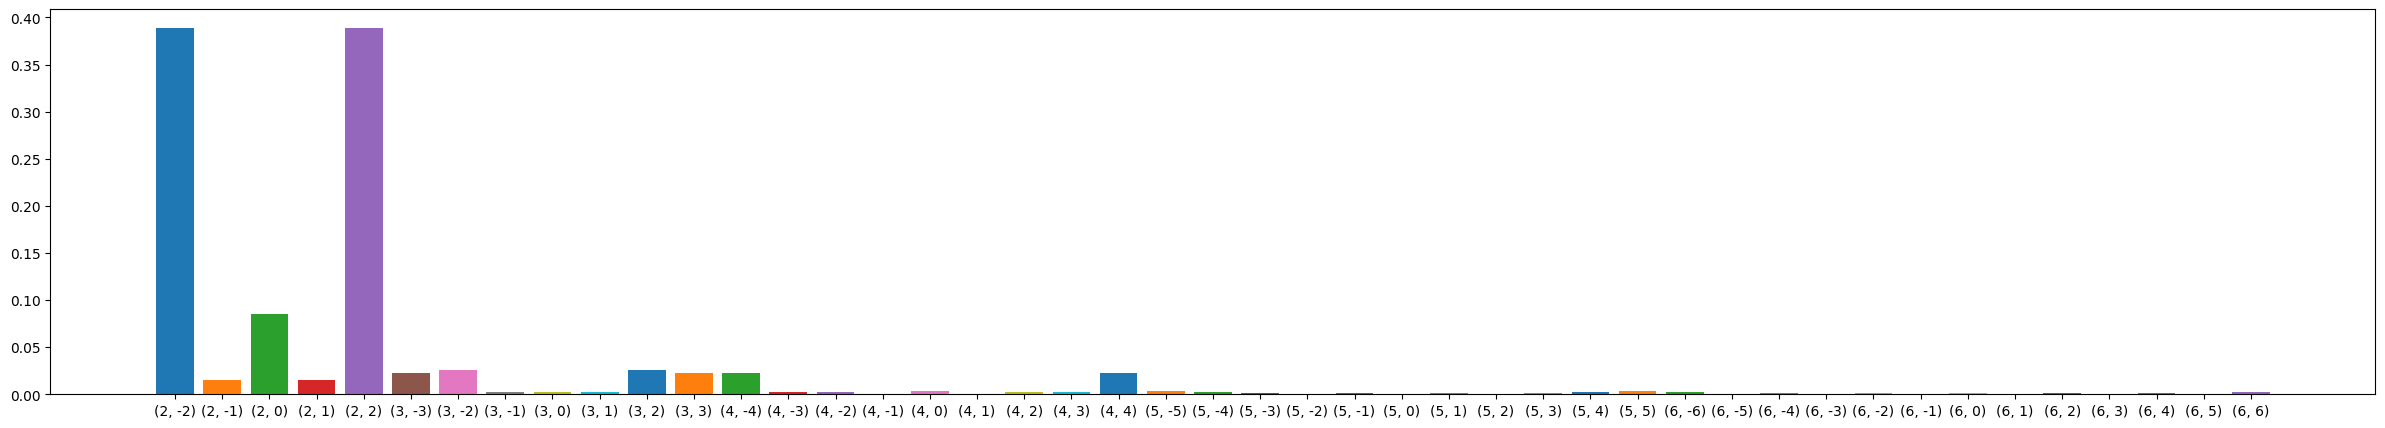

In [4]:
quadratic_mode = (2,2,0,1,2,-2,0,-1) 
spherical_mode = (2,0) 
t0 = 20
sim = CCE_sim305
#CCE_sim12

l,m = spherical_mode 
lp,mp,nprime,pp,lpp,mpp,npp,ppp = quadratic_mode

fig, ax = plt.subplots(figsize=(30,5)) 

for mode in sim.h.keys(): 
    if mode[0] < 7: 
        plt.bar(str(mode), abs(sim.h[mode]).max()) 

#plt.plot(sim.times, sim.h[l,m].real) 
#plt.plot(sim.times, sim.h[l,m].imag)
#plt.xlim(0,100)

In [5]:
start_times = np.array([0, 10.0, 20.0, 30.0])

#sims = [CCE_sim1, CCE_sim2, CCE_sim3, CCE_sim4, CCE_sim5, CCE_sim6, CCE_sim7, CCE_sim8, CCE_sim9, CCE_sim10, CCE_sim11, CCE_sim12, CCE_sim13]
sims = [sim_1502, sim_1476, sim_1506, sim_1508, sim_1474, sim_1505, sim_1504, sim_1485, sim_1486, sim_1441, sim_1500, sim_1492, sim_1465, 
        sim_1458, sim_1438, sim_1430]

amp_array = np.zeros((5, len(start_times), len(sims)))

# Define the linear models to compare to the quadratic model

model_l1 = [(lp,mp,n_i,1) for n_i in range(1+1)] 
model_l2 = [(lpp,mpp,n_i,-1) for n_i in range(1+1)] 

model_l3 = [(l,m,n_i,1) for n_i in range(2+1)] + [(l,m,n_i,-1) for n_i in range(1+1)] # N=1 to keep same number of DoF
model_q = [(l,m,n_i,1) for n_i in range(1+1)] + [(l,m,n_i,-1) for n_i in range(1+1)] + [quadratic_mode]

l1_amp_index = model_l1.index((lp,mp,0,1))
l2_amp_index = model_l2.index((lpp,mpp,0,-1))
l3_amp_index = model_l3.index((l,m,0,1))
q_amp_index = model_q.index(quadratic_mode)

for j, t_start in enumerate(start_times):

    for i, s in enumerate(sims):

        decay_time_1 = qnmfits.qnm.omega(lp,mp,0,1, s.chif_mag, Mf=s.Mf).imag
        decay_time_2 = qnmfits.qnm.omega(lpp,mpp,0,1, s.chif_mag, Mf=s.Mf).imag
        decay_time_3 = qnmfits.qnm.omega(l,m,0,1, s.chif_mag, Mf=s.Mf).imag
        decay_time_q = qnmfits.qnm.omega(lp,mp,nprime,pp, s.chif_mag, Mf=s.Mf).imag + qnmfits.qnm.omega(lpp,mpp,npp,ppp, s.chif_mag, Mf=s.Mf).imag

        best_fit_l1 = qnmfits.ringdown_fit(
            s.times,
            s.h[lp,mp],
            model_l1,
            Mf=s.Mf,
            chif=s.chif_mag,
            t0=t_start,
        )

        best_fit_l2 = qnmfits.ringdown_fit(
            s.times,
            s.h[lpp,mpp],
            model_l2,
            Mf=s.Mf,
            chif=s.chif_mag,
            t0=t_start,
        )

        amp_array[0][j][i] = abs(best_fit_l1['C'][l1_amp_index]*np.exp(-decay_time_1*t_start)) * \
                             abs(best_fit_l2['C'][l2_amp_index]*np.exp(-decay_time_2*t_start))

        best_fit_l3 = qnmfits.ringdown_fit(
            s.times,
            s.h[l,m],
            model_l3,
            Mf=s.Mf,
            chif=s.chif_mag,
            t0=t_start,
        )

        amp_array[1][j][i] = abs(best_fit_l3['C'][l3_amp_index]*np.exp(-decay_time_3*t_start))

        best_fit_q = qnmfits.ringdown_fit(
            s.times,
            s.h[l,m],
            model_q,
            Mf=s.Mf,
            chif=s.chif_mag,
            t0=t_start,
        )

        amp_array[2][j][i] = abs(best_fit_q['C'][q_amp_index]*np.exp(-decay_time_q*t_start))
        
        amp_array[3][j][i] = s.m1 / s.m2

        if 0.6 < s.chif_mag < 0.8:
            amp_array[4][j][i] = 1
        if 0.4 < s.chif_mag < 0.6:
            amp_array[4][j][i] = 2


In [6]:
def quadratic_model_error(a, x, y):
    return a * x - y

coefs = [] 

for j, _ in enumerate(start_times): 

    x_data = amp_array[0][j]
    y_data = amp_array[2][j]
    initial_params = [1]

    result = least_squares(quadratic_model_error, initial_params, args=(x_data, y_data))
    fitted_params = result.x 

    print("a =", fitted_params[0])

    a = fitted_params[0]
    coefs.append(a) 

a = 0.008966807206681526
a = 0.030235986130039416
a = 0.05883401166257196
a = 0.17065220224437005


/tmp/ipykernel_26501/2117434637.py:41: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


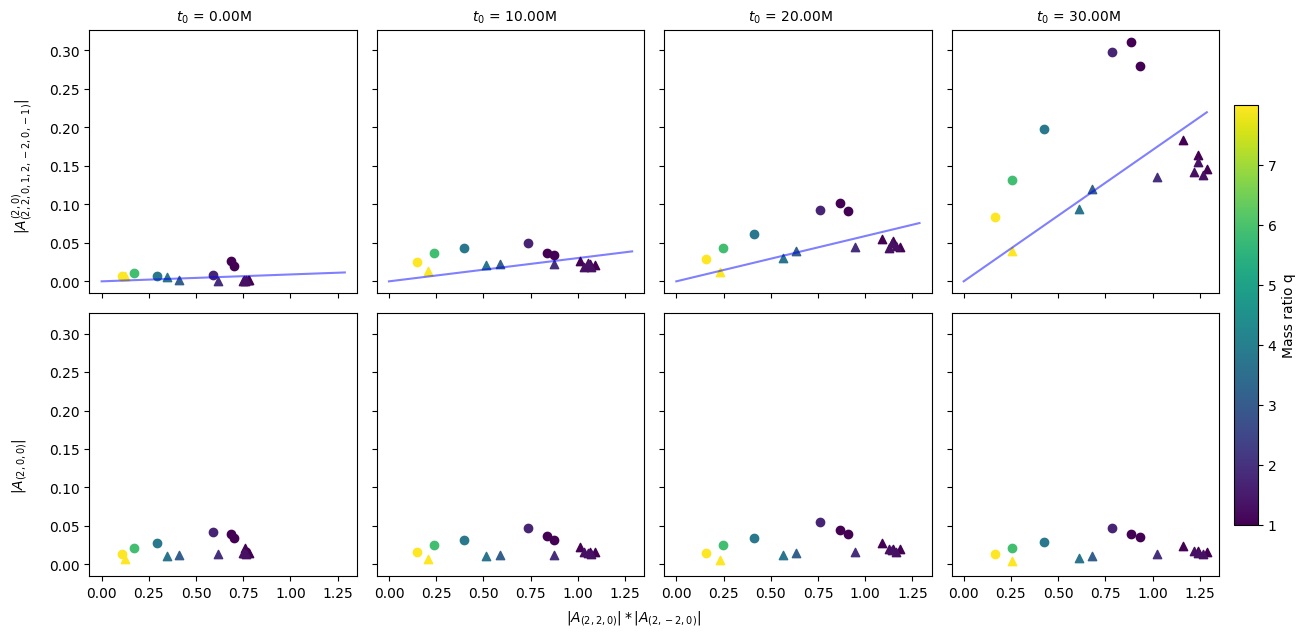

In [7]:
import matplotlib.ticker as mticker

xs = np.linspace(0, np.max(amp_array[0]), 100)

fig, axs = plt.subplots(2, 4, figsize=(12, 6), sharex=True, sharey=True)

cmap = plt.get_cmap('viridis')
vmin = np.min(amp_array[3])
vmax = np.max(amp_array[3])

shape_dict = {1: '^', 2: 'o'} 

for i in range(len(sims)):
    for j in range(len(start_times)):
        shape = shape_dict[amp_array[4][j][i]] 
        plot1 = axs[0,j].scatter(amp_array[0][j][i], amp_array[2][j][i], c=amp_array[3][j][i], cmap=cmap, marker=shape, vmin=vmin, vmax=vmax)
        axs[1,j].scatter(amp_array[0][j][i], amp_array[1][j][i], c=amp_array[3][j][i], cmap=cmap, marker=shape, vmin=vmin, vmax=vmax)

axs[0,0].plot(xs, coefs[0]*xs, c='blue', alpha=0.5)
axs[0,1].plot(xs, coefs[1]*xs, c='blue', alpha=0.5)
axs[0,2].plot(xs, coefs[2]*xs, c='blue', alpha=0.5)
axs[0,3].plot(xs, coefs[3]*xs, c='blue', alpha=0.5)

cbar_ax = fig.add_axes([1, 0.15, 0.02, 0.7])  
fig.colorbar(plot1, cax=cbar_ax, label='Mass ratio q')

fig.text(0.5, -0.01, f'$|A_{{({lp},{mp},0)}}|*|A_{{({lpp},{mpp},0)}}|$', ha='center')
fig.text(0.15, 0.99, f'$t_0$ = {start_times[0]:.2f}M', ha='center')
fig.text(0.4, 0.99, f'$t_0$ = {start_times[1]:.2f}M', ha='center')
fig.text(0.63, 0.99, f'$t_0$ = {start_times[2]:.2f}M', ha='center')
fig.text(0.87, 0.99, f'$t_0$ = {start_times[3]:.2f}M', ha='center')
fig.text(-0.02, 0.25, f'$|A_{{({l},{m},0)}}|$', va='center', rotation='vertical')
fig.text(-0.02, 0.75, f'$|A_{{{quadratic_mode}}}^{{{spherical_mode}}}|$', va='center', rotation='vertical')

#axs[0,0].xaxis.set_major_formatter(mticker.FormatStrFormatter('%.1f'))
#axs[0,0].yaxis.set_major_formatter(mticker.FormatStrFormatter('%.1f'))
#axs[0,0].yaxis.set_major_locator(mticker.MultipleLocator(0.1))
#axs[0,0].set_ylim(0, 0.21)
#axs[0,0].set_xlim(0, 1.1)

plt.tight_layout()

# Reproducing Fig. 2

In [8]:
model_l3 = [(l,m,n,1) for n in range(2+1)] + [(l,m,n,-1) for n in range(1+1)]
model_q = [(l,m,n,1) for n in range(1+1)] + [(l,m,n,-1) for n in range(1+1)] + [quadratic_mode]

print(model_l3)
print(model_q)

best_fit_l2 = qnmfits.ringdown_fit(
    sim.times,
    sim.h[l,m],
    model_l3,
    Mf=sim.Mf,
    chif=sim.chif_mag,
    t0=t0,
)
    
best_fit_q = qnmfits.ringdown_fit(
    sim.times,
    sim.h[l,m],
    model_q,
    Mf=sim.Mf,
    chif=sim.chif_mag,
    t0=t0,
)

[(2, 0, 0, 1), (2, 0, 1, 1), (2, 0, 2, 1), (2, 0, 0, -1), (2, 0, 1, -1)]
[(2, 0, 0, 1), (2, 0, 1, 1), (2, 0, 0, -1), (2, 0, 1, -1), (2, 2, 0, 1, 2, -2, 0, -1)]


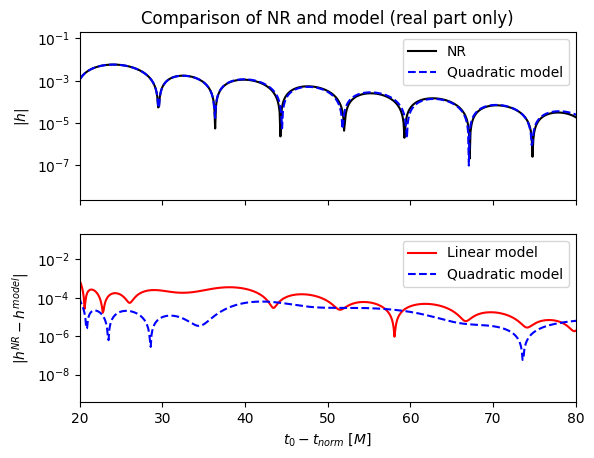

In [9]:
fig, ax = plt.subplots(ncols=1, nrows=2, sharex=True)

ax[0].set_title('Comparison of NR and model (real part only)')

ax[0].plot(sim.times, abs(sim.h[l,m].real), c='black', label = 'NR') 
ax[0].plot(best_fit_q['model_times'], abs(best_fit_q['model'].real), c='b', linestyle='dashed', label = 'Quadratic model')
ax[1].set_xlabel('$t_0 - t_{norm}\ [M]$')
ax[0].set_ylabel('$|h|$')
ax[0].legend()
ax[0].set_yscale('log')
ax[0].set_xlim(t0, 80)
#ax[0].set_ylim(1e-6, 1e-1)

interpolated_model_l2 = np.interp(sim.times, best_fit_l2['model_times'], best_fit_l2['model'])
interpolated_model_q = np.interp(sim.times, best_fit_q['model_times'], best_fit_q['model'])

ax[1].set_ylabel('$|h^{NR} - h^{model}|$')
ax[1].plot(sim.times, abs(sim.h[l,m] - interpolated_model_l2), c='r', label = 'Linear model')
ax[1].plot(sim.times, abs(sim.h[l,m] - interpolated_model_q), c='b', linestyle='dashed', label = 'Quadratic model')
ax[1].set_yscale('log')
ax[1].legend()


# Reproducing Fig. 3

5
5


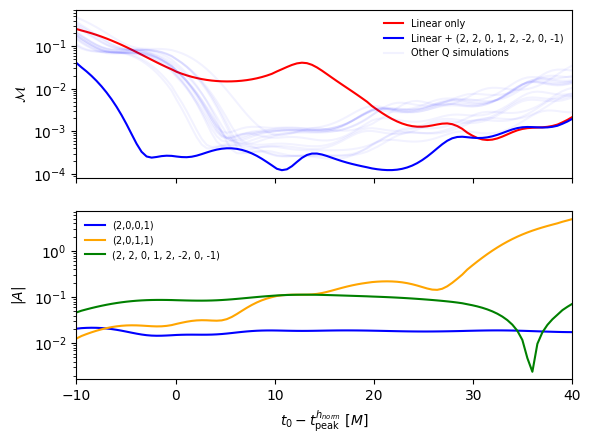

In [10]:
model_l3 = [(l,m,n_i,1) for n_i in range(2+1)] + [(l,m,n_i,-1) for n_i in range(1+1)]
model_q = [(l,m,n_i,1) for n_i in range(1+1)] + [(l,m,n_i,-1) for n_i in range(1+1)] + [quadratic_mode]

print(len(model_l3))
print(len(model_q))

q1_amp_index = model_q.index((l,m,0,1))
q2_amp_index = model_q.index((l,m,1,1))
q3_amp_index = model_q.index(quadratic_mode)

mode_list = [model_l3, model_q]
mode_list_names = ['Linear only', f'Linear + {quadratic_mode}']
mode_colours = ['r', 'b']

# Generate main two lines of plots  

start_times = np.linspace(-10, 40, 100)
fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True)

for i, modes in enumerate(mode_list):

    quad_bool = False

    if mode_list_names[i] == f'Linear + {quadratic_mode}':
        quad_bool = True
        amplitudes = []
        amplitudes1 = []
        amplitudesq = []  

    mms = []  

    for j, t_start in enumerate(start_times):

        best_fit = qnmfits.ringdown_fit(
            sim.times,
            sim.h[l,m],
            modes,
            Mf=sim.Mf,
            chif=sim.chif_mag,
            t0=t_start
        )

        mms.append(best_fit['mismatch'])

        if quad_bool:
            amplitudes.append(abs(best_fit['C'][q1_amp_index]))
            amplitudes1.append(abs(best_fit['C'][q2_amp_index]))
            amplitudesq.append(abs(best_fit['C'][q3_amp_index]))
    
    ax[0].semilogy(start_times, mms, label=mode_list_names[i], color=mode_colours[i])

    if quad_bool:

        decay_time_l1 = qnmfits.qnm.omega(l,m,0,1, s.chif_mag, Mf=s.Mf).imag
        decay_time_l2 = qnmfits.qnm.omega(l,m,1,1, s.chif_mag, Mf=s.Mf).imag
        decay_time_q = qnmfits.qnm.omega(lp,mp,nprime,pp, s.chif_mag, Mf=s.Mf).imag + qnmfits.qnm.omega(lpp,mpp,npp,ppp, s.chif_mag, Mf=s.Mf).imag

        ax[1].semilogy(start_times, amplitudes*np.exp(-decay_time_l1*start_times), label=f'({l},{m},0,1)', c='b') 
        ax[1].semilogy(start_times, amplitudes1*np.exp(-decay_time_l2*start_times), label=f'({l},{m},1,1)', c='orange')
        ax[1].semilogy(start_times, amplitudesq*np.exp(-decay_time_q*start_times), label=f'{quadratic_mode}', c='g')

# Generate other simulation plots 

sims = [sim_1502, sim_1476, sim_1506, sim_1508, sim_1474, sim_1505, sim_1504, sim_1485, sim_1486, sim_1441, sim_1500, sim_1492, sim_1465, 
        sim_1458, sim_1438, sim_1430]

for i, s in enumerate(sims):

    mms = []  

    for j, t_start in enumerate(start_times):

        best_fit = qnmfits.ringdown_fit(
            s.times,
            s.h[l,m],
            model_q,
            Mf=s.Mf,
            chif=s.chif_mag,
            t0=t_start
        )

        mms.append(best_fit['mismatch'])

    if i == len(sims) - 1:
        ax[0].semilogy(start_times, mms, alpha = 0.05, c='b', label='Other Q simulations')
    else:
        ax[0].semilogy(start_times, mms, alpha = 0.05, c='b')

ax[1].set_xlim(start_times[0], start_times[-1])
ax[1].set_xlabel('$t_0 - t^{h_{norm}}_\mathrm{peak}\ [M]$')
ax[0].set_ylabel('$\mathcal{M}$')
ax[1].set_ylabel('$|A|$')

_ = ax[0].legend(ncol=1, frameon=False, fontsize=7)
_ = ax[1].legend(ncol=1, frameon=False, fontsize=7)

# Reproduction of Fig. 4

In [11]:
model_q = [(l,m,n,1) for n in range(1+1)] + [(l,m,n,-1) for n in range(1+1)] + [quadratic_mode]

re_min = -0.5
re_max = 0.5
im_min = -0.5
im_max = 0.5
step = 101

index = model_q.index(quadratic_mode)

In [12]:
im_variation = np.linspace(im_min, im_max, step)
re_variation = np.linspace(re_min, re_max, step)

frequencies = np.array(qnm.omega_list(model_q, sim.chif_mag, sim.Mf))

mm_list = [] 

for v_im in im_variation:
    for v_re in re_variation:

        modified_frequencies = frequencies.copy()

        if modified_frequencies[index].imag == 0:
            modified_frequencies[index] = frequencies[index].real * (1 + v_re) + 1j * v_im
        elif modified_frequencies[index].real == 0:
            modified_frequencies[index] = v_re + 1j * frequencies[index].imag * (1 + v_im) 
        else:
            modified_frequencies[index] = frequencies[index].real * (1 + v_re) + 1j * frequencies[index].imag * (1 + v_im)

        best_fit = qnmfits.ringdown_fit(
            sim.times,
            sim.h[l,m],
            model_q,
            Mf=sim.Mf,
            chif=sim.chif_mag,
            t0=t0,
            frequencies = modified_frequencies
        )

        mm_list.append(best_fit['mismatch'])

mm_grid = np.reshape(
    np.array(mm_list), (step, step)
    )

Text(0, 0.5, 'Im($\\omega_{(2, 2, 0, 1, 2, -2, 0, -1)}^{(2, 0)}$)')

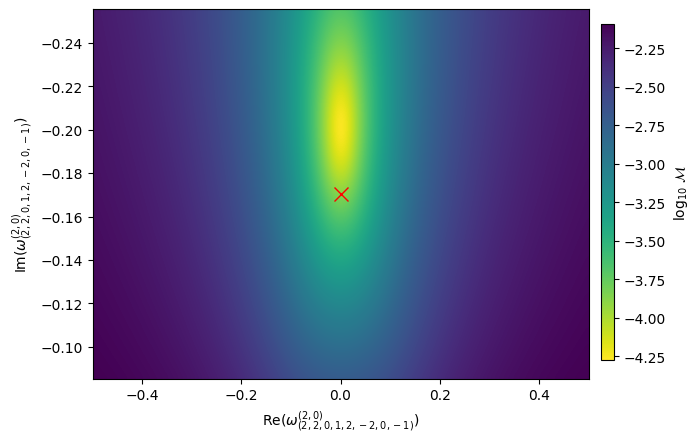

In [13]:
fig, ax = plt.subplots() 

xmin = frequencies[index].real*(1 + re_min) 
xmax = frequencies[index].real*(1 + re_max) 
ymin = frequencies[index].imag*(1 + im_min)
ymax = frequencies[index].imag*(1 + im_max) 

if frequencies[index].imag == 0:
    ymin = im_min
    ymax = im_max
elif frequencies[index].real == 0:
    xmin = re_min
    xmax = re_max

# Plot heatmap
im = ax.imshow(
    np.log10(mm_grid), 
    extent=[xmin, xmax, ymin, ymax],
    aspect='auto',
    origin='lower',
    interpolation='bicubic',
    cmap='viridis_r')

ax.plot(frequencies[index].real, frequencies[index].imag, color='r', marker='x', markersize=10)

#next_freq = qnmfits.qnm.omega(l,m,2,1, s.chif_mag, Mf=s.Mf)
#ax.plot(next_freq.real, next_freq.imag, color='y', marker='o', markersize=10)

#frequency_442= np.array(qnm.omega_list([(4,4,2,1)], sim.chif_mag, sim.Mf))
#x_offset = frequency_442.real / frequencies.real[index]
#y_offset = frequency_442.imag / frequencies.imag[index]

#ax.plot(x_offset, y_offset, marker='o', markersize=3, color='k')

# Color bar
cax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
cbar = fig.colorbar(im, cax=cax)
cbar.ax.set_ylabel('$\mathrm{log}_{10}\ \mathcal{M}$')

ax.set_xlabel(f'Re($\omega_{{{quadratic_mode}}}^{{{spherical_mode}}}$)')
ax.set_ylabel(f'Im($\omega_{{{quadratic_mode}}}^{{{spherical_mode}}}$)')

# Fig. 4 with all frequencies plotted

In [14]:
model_q = [(l,m,n,1) for n in range(1+1)] + [(l,m,n,-1) for n in range(1+1)] + [quadratic_mode]

re_min = -1.2
re_max = 1.7
im_min = -0.6
im_max = 0.25
step = 101 

index = model_q.index(quadratic_mode)

In [15]:
im_variation = np.linspace(im_min, im_max, step)
re_variation = np.linspace(re_min, re_max, step)

frequencies = np.array(qnm.omega_list(model_q, sim.chif_mag, sim.Mf))

mm_list = [] 

for v_im in im_variation:
    for v_re in re_variation:

        modified_frequencies = frequencies.copy()

        modified_frequencies[index] = v_re + 1j * v_im

        best_fit = qnmfits.ringdown_fit(
            sim.times,
            sim.h[l,m],
            model_q,
            Mf=sim.Mf,
            chif=sim.chif_mag,
            t0=t0,
            frequencies = modified_frequencies
        )

        mm_list.append(best_fit['mismatch'])

mm_grid = np.reshape(
    np.array(mm_list), (step, step)
    )

Text(0, 0.5, 'Im($\\omega_{(2, 2, 0, 1, 2, -2, 0, -1)}^{(2, 0)}$)')

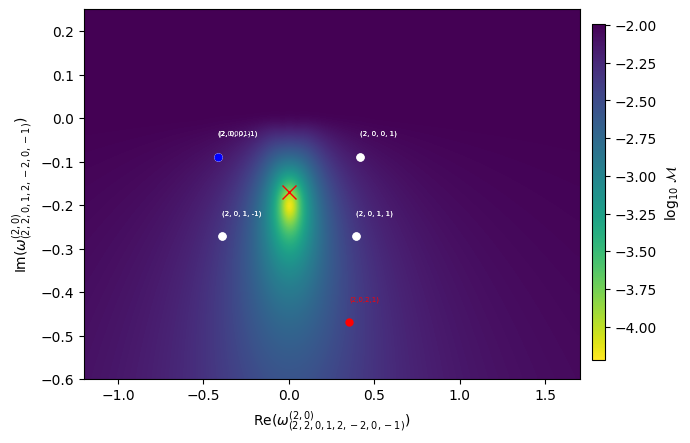

In [16]:
fig, ax = plt.subplots() 

xmin = re_min
xmax = re_max
ymin = im_min
ymax = im_max

# Plot heatmap
im = ax.imshow(
    np.log10(mm_grid), 
    extent=[xmin, xmax, ymin, ymax],
    aspect='auto',
    origin='lower',
    interpolation='bicubic',
    cmap='viridis_r')


ax.plot(frequencies[index].real, frequencies[index].imag, color='r', marker='x', markersize=10)

for i, freq in enumerate(frequencies):
    if freq != frequencies[index]:
        ax.plot(freq.real, freq.imag, color='w', marker='o', markersize=5)
        ax.text(freq.real, freq.imag+0.05, f'{model_q[i]}', fontsize=5, color='w')
        ax.plot(-freq.real, freq.imag, color='w', marker='o', markersize=5)
        ax.text(freq.real, freq.imag+0.05, f'{model_q[i]}', fontsize=5, color='w')

next_freq = qnmfits.qnm.omega(l,m,2,1, sim.chif_mag, Mf=sim.Mf)
ax.plot(next_freq.real, next_freq.imag, color='r', marker='o', markersize=5)
ax.text(next_freq.real, next_freq.imag+0.05, f'({l},{m},2,1)', fontsize=5, color='r')

other_freq = qnmfits.qnm.omega(l,m,0,-1, sim.chif_mag, Mf=sim.Mf)
ax.plot(other_freq.real, other_freq.imag, color='blue', marker='o', markersize=5)
ax.text(other_freq.real, other_freq.imag+0.05, f'({l},{m},0,-1)', fontsize=5, color='white')

"""
all_qnms = [(lam,mu,n,p) for lam in np.arange(2, 4+1, 2)
                        for mu in np.arange(-lam, lam+1, 2)
                           for n in np.arange(0, 2+1)
                              for p in (-1, +1)]

all_freqs = np.array(qnm.omega_list(all_qnms, sim.chif_mag, sim.Mf))
for i, freq in enumerate(all_freqs):
    ax.plot(freq.real, freq.imag, color='y', marker='o', markersize=2)
    ax.text(freq.real, freq.imag*0.8, f'{all_qnms[i]}', fontsize=5, color='w')
""" 

#frequency_442= np.array(qnm.omega_list([(4,4,2,1)], sim.chif_mag, sim.Mf))
#x_offset = frequency_442.real / frequencies.real[index]
#y_offset = frequency_442.imag / frequencies.imag[index]

#ax.plot(x_offset, y_offset, marker='o', markersize=3, color='k')

# Color bar
cax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
cbar = fig.colorbar(im, cax=cax)
cbar.ax.set_ylabel('$\mathrm{log}_{10}\ \mathcal{M}$')

ax.set_xlabel(f'Re($\omega_{{{quadratic_mode}}}^{{{spherical_mode}}}$)')
ax.set_ylabel(f'Im($\omega_{{{quadratic_mode}}}^{{{spherical_mode}}}$)')

## Check amplitudes

In [17]:
qnms = [(2,2,0,1,2,-2,0,-1), (3,3,0,1,3,-3,0,-1), (4,4,0,1,4,-4,0,-1), (5,5,0,1,5,-5,0,-1), (6,6,0,1,6,-6,0,-1), (7,7,0,1,7,-7,0,-1)]
#qnms = [(2,2,0,1), (3,3,0,1), (4,4,0,1), (5,5,0,1), (6,6,0,1), (7,7,0,1)]

frequencies = np.array(qnm.omega_list(qnms, sim.chif_mag, sim.Mf))

print(frequencies)

[0.-0.17034469j 0.-0.17478195j 0.-0.17772099j 0.-0.17942587j
 0.-0.18047588j 0.-0.18116328j]


In [18]:



best_fit = qnmfits.ringdown_fit(
        sim.times,
        sim.h[l,m],
        model_q,
        Mf=sim.Mf,
        chif=sim.chif_mag,
        t0=t0
    )

print(model_q)
print(abs(best_fit['C']))

[(2, 0, 0, 1), (2, 0, 1, 1), (2, 0, 0, -1), (2, 0, 1, -1), (2, 2, 0, 1, 2, -2, 0, -1)]
[0.00321983 0.00095526 0.00321983 0.00095526 0.00321424]


-p modes are important for these m=0 models (and n>0 amplitudes are smaller and therefore could be removed). 